In [ ]:
# импорт библиотек

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import cv2
import warnings
warnings.filterwarnings('ignore')

# библиотеки для обучения моделей

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D,GlobalAveragePooling2D, Flatten,Dropout

from tensorflow.keras.applications import ResNet152V2

In [ ]:
import os
from google.colab import files
from google.colab import drive
import zipfile


# Подключение Google Drive
drive.mount('/content/drive')
zip_file = '/content/drive/MyDrive/archive.zip'

z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

Mounted at /content/drive
['.config', 'raw-img', 'drive', 'translate.py', 'sample_data']


In [ ]:
sourse_data = 'raw-img'
print(len(os.listdir(sourse_data)))
class_name_ori = sorted(os.listdir(sourse_data))
print(class_name_ori)

10
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [ ]:
class_names_dict = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

In [ ]:
class_count = []
for name in class_name_ori:
    clas_size = len(os.listdir(os.path.join(sourse_data,name)))
    class_count.append(clas_size)

class_name_en = sorted([class_names_dict[i] for i in class_name_ori])

class_size = dict(zip(class_name_en, class_count))

class_size

{'butterfly': 4863,
 'cat': 2623,
 'chicken': 1446,
 'cow': 2112,
 'dog': 3098,
 'elephant': 1668,
 'horse': 1866,
 'sheep': 1820,
 'spider': 4821,
 'squirrel': 1862}

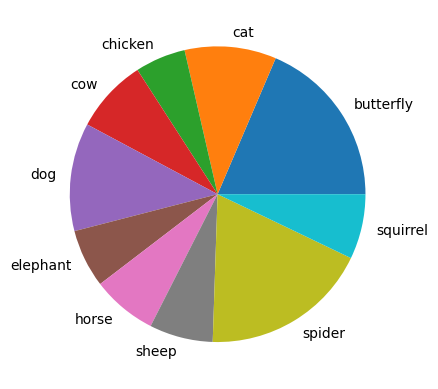

In [ ]:
# построение гистограммы и круговой диаграммы

plt.pie(x = class_count, labels= class_name_en)
plt.show()

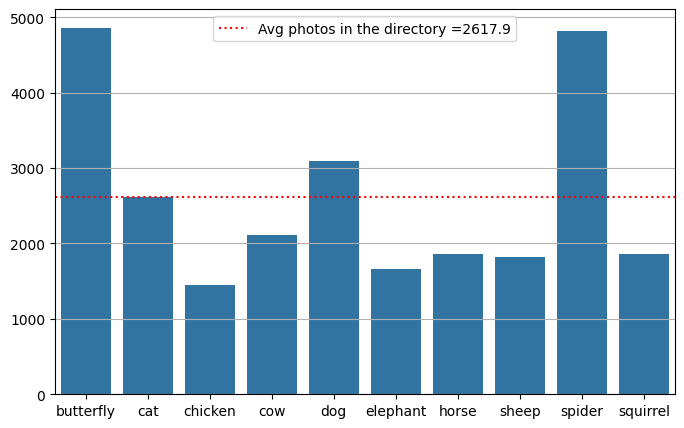

In [ ]:
plt.figure(figsize=(8,5))
plt.grid()
sns.barplot(x = class_name_en,y = class_count)
plt.axhline(np.mean(class_count), linestyle = ':',color = 'r' ,label = f'Avg photos in the directory ={np.mean(class_count)}')
plt.legend()
plt.show()

In [ ]:
## создание папки проверки и обучения
## создание дерикторий для папок
data_path = 'data_path2'
training_folder = os.path.join(data_path, 'training2')
validation_folder = os.path.join(data_path, 'validation2')

def create_train_validation(root_path, training_folder, validation_folder):
    folders = []

    folders.append(training_folder)
    folders.append(validation_folder)

    for name in class_names_dict.values():
        folders.append(os.path.join(training_folder, name))
        folders.append(os.path.join(validation_folder, name))

    for file in folders:
        if not os.path.exists(file):
            os.makedirs(file)

try:
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    create_train_validation(data_path, training_folder, validation_folder)

except FileExistsError:
    print("Folders are alredy exixsting. please deleting them and create new !!!!")

In [ ]:
# Разделение данных на обучающую и валидационную выборки

def split_data(data_path, training_path, validation_path, data_size):

    data = []
    for file in os.scandir(data_path):
        if os.path.getsize(file.path) > 0:
            data.append(file.name)
        else:
            print(f"{file.name} is Zero legnth, so ignoring !!!")

        trainig_size = int(data_size * 0.8)
        shuffled_data = np.random.choice(data, size = data_size, replace = True)

        training_Data = shuffled_data[0: trainig_size]
        validation_data = shuffled_data[trainig_size:]

    for file in training_Data:
        shutil.copy(os.path.join(data_path, file), os.path.join(training_path,file))

    for file in validation_data:
        shutil.copy(os.path.join(data_path,file), os.path.join(validation_path,file))
def copy_files_Directory(training_dir, validation_dir):
    for name in class_name_ori:
        data_path = os.path.join(sourse_data, name)
        class_eng_name = class_names_dict[name]

        training_class = os.path.join(training_dir, class_eng_name)
        validation_class = os.path.join(validation_dir, class_eng_name)

        data_size = class_size[class_eng_name]

        data_size = 2100 if  data_size > 2100 else data_size

        if len(os.listdir(training_class)) == 0 and len(os.listdir(validation_class)) == 0:
            print(data_path, training_class, validation_class)
            split_data(data_path,training_class, validation_class, data_size)

copy_files_Directory(training_folder, validation_folder)

raw-img/cane data_path2/training2/dog data_path2/validation2/dog
raw-img/cavallo data_path2/training2/horse data_path2/validation2/horse
raw-img/elefante data_path2/training2/elephant data_path2/validation2/elephant
raw-img/farfalla data_path2/training2/butterfly data_path2/validation2/butterfly
raw-img/gallina data_path2/training2/chicken data_path2/validation2/chicken
raw-img/gatto data_path2/training2/cat data_path2/validation2/cat
raw-img/mucca data_path2/training2/cow data_path2/validation2/cow
raw-img/pecora data_path2/training2/sheep data_path2/validation2/sheep
raw-img/ragno data_path2/training2/spider data_path2/validation2/spider
raw-img/scoiattolo data_path2/training2/squirrel data_path2/validation2/squirrel


In [ ]:
# Генерация аугментированных данных для обучения и валидации

def train_agumentation(training_dir, validation_dir):

    train_genrator = ImageDataGenerator(rescale=(1./255.),
                                        horizontal_flip= True,
                                        shear_range= 0.2,
                                       height_shift_range= 0.2,
                                       width_shift_range= 0.2,
                                       rotation_range= 20,
                                       fill_mode= 'nearest')

    train_genrator_img = train_genrator.flow_from_directory(training_dir,
                                                           target_size= (256,256),
                                                           class_mode= 'categorical',
                                                            shuffle= True,
                                                            batch_size= 16)


    validation_gerator = ImageDataGenerator(rescale=(1./255.))  ## original data for validation

    validation_gerator_img = validation_gerator.flow_from_directory(validation_dir,
                                                           target_size= (256,256),
                                                           class_mode= 'categorical',
                                                            shuffle= True,
                                                            batch_size= 16)

    return train_genrator_img, validation_gerator_img


In [ ]:
train_data , validation_data = train_agumentation(training_folder, validation_folder)

Found 11140 images belonging to 10 classes.
Found 3514 images belonging to 10 classes.


In [ ]:
# train_data[30][1]

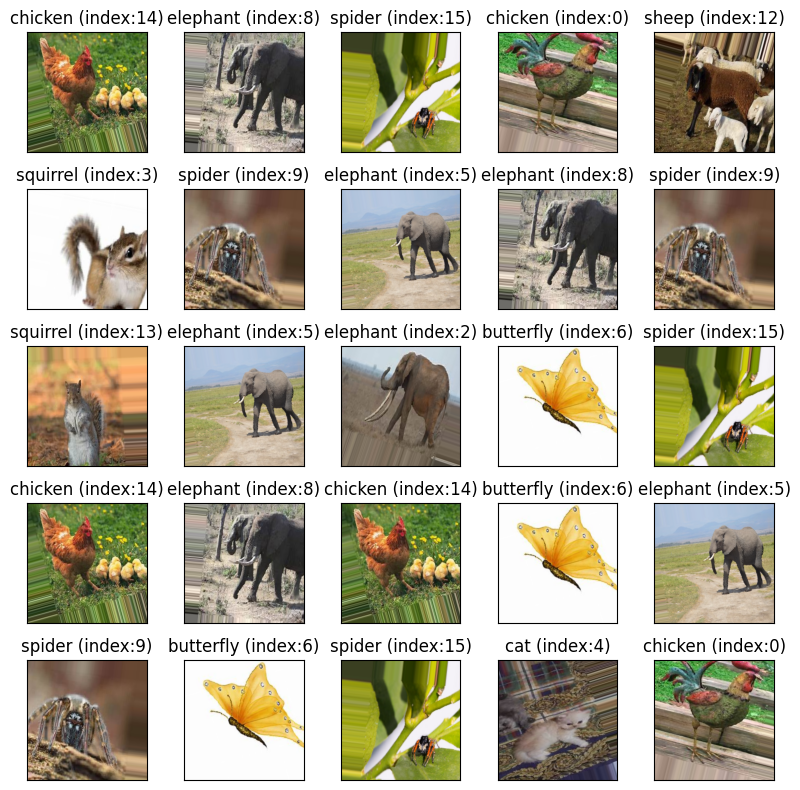

In [ ]:
# Отображение случайных изображений из обучающего набора

plt.figure(figsize= (8,8))
for img, label in iter(train_data):
    count = 1
    while(count <= 25):
        random_idx = np.random.choice(len(img), replace = False)
        imgs, labels = img[random_idx], label[random_idx]

        plt.subplot(5,5, count)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imgs)
        plt.title(f'{class_name_en[int(np.argmax(labels))]} (index:{random_idx})')
        count +=1
    if count == 26:
        break
plt.tight_layout()
plt.show()

In [ ]:
mobileLayer = ResNet152V2(input_shape = (256,256,3), weights= 'imagenet', include_top = False)
mobileLayer.trainable = False

mobileLayer.summary()

234545216/234545216 [==============================] - 2s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                     

In [ ]:
# Создание модели Keras с использованием ResNet152V2 и полносвязными слоями

model = tf.keras.Sequential([
    mobileLayer,
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(10, activation= 'softmax')

],name = 'kaggle_model')

In [ ]:
model.summary()

Model: "kaggle_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 58858762 (224.53 MB)
Trainable params: 527114 (2.01 MB)
Non-trainable params: 58331648 (222.52 MB)
_______

In [ ]:
# Компиляция модели с оптимизатором Adam и метрикой точности

model.compile(loss= tf.keras.losses.CategoricalCrossentropy(), # labels are onehot encoded
             optimizer= tf.keras.optimizers.Adam(1e-5),
             metrics= ['accuracy'])

In [ ]:
# Определение пользовательского обратного вызова для остановки обучения при достижении определенного уровня точности

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs):
        if logs['accuracy'] > 0.95:
            model.stop_training = True

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is here")
else:
    print("NOOOOPEEE")

GPU is here


In [ ]:
# Обучение модели с использованием пользовательского обратного вызова для контроля процесса

history = model.fit(train_data,
         epochs= 30,
         validation_data= validation_data,
         batch_size = 16, shuffle= True, callbacks= [CustomCallback()])

Epoch 1/30
697/697 [==============================] - 267s 361ms/step - loss: 1.5063 - accuracy: 0.5350 - val_loss: 0.5996 - val_accuracy: 0.8939
Epoch 2/30
697/697 [==============================] - 245s 351ms/step - loss: 0.5588 - accuracy: 0.8612 - val_loss: 0.2858 - val_accuracy: 0.9417
Epoch 3/30
697/697 [==============================] - 245s 351ms/step - loss: 0.3589 - accuracy: 0.9048 - val_loss: 0.2057 - val_accuracy: 0.9493
Epoch 4/30
697/697 [==============================] - 245s 352ms/step - loss: 0.2869 - accuracy: 0.9178 - val_loss: 0.1698 - val_accuracy: 0.9550
Epoch 5/30
697/697 [==============================] - 245s 351ms/step - loss: 0.2426 - accuracy: 0.9293 - val_loss: 0.1476 - val_accuracy: 0.9619
Epoch 6/30
697/697 [==============================] - 255s 366ms/step - loss: 0.2296 - accuracy: 0.9323 - val_loss: 0.1335 - val_accuracy: 0.9624
Epoch 7/30
697/697 [==============================] - 245s 351ms/step - loss: 0.2009 - accuracy: 0.9398 - val_loss: 0.1251 -

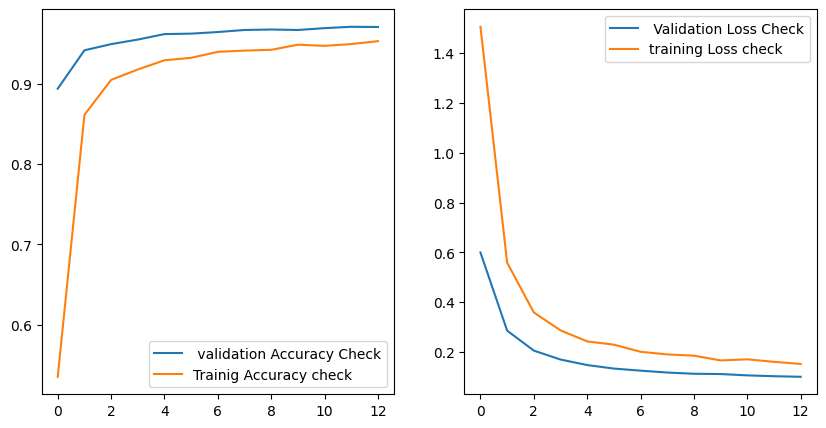

In [ ]:
# Визуализация изменений точности и потерь во время обучения

epochs = range(len(history.history['accuracy']))
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(epochs, history.history['val_accuracy'], label = ' validation Accuracy Check')
ax[0].plot(epochs, history.history['accuracy'], label = 'Trainig Accuracy check')
ax[0].legend()

ax[1].plot(epochs, history.history['val_loss'], label = ' Validation Loss Check')
ax[1].plot(epochs, history.history['loss'], label = 'training Loss check')
ax[1].legend()

plt.show()

In [ ]:
# Функция для отображения предсказаний на оригинальных изображениях

def show_img(prediction, original):
    for i in range(len(original)):
        print(i)
        img = cv2.imread(original[i])
        plt.imshow(img)
        plt.title(f"Prediction: {class_name_en[np.argmax(prediction[i])]}")
        plt.show()

In [ ]:
model.save('model.keras')
loaded_model = tf.keras.models.load_model("model.keras")

1/1 [==============================] - 0s 49ms/step
0


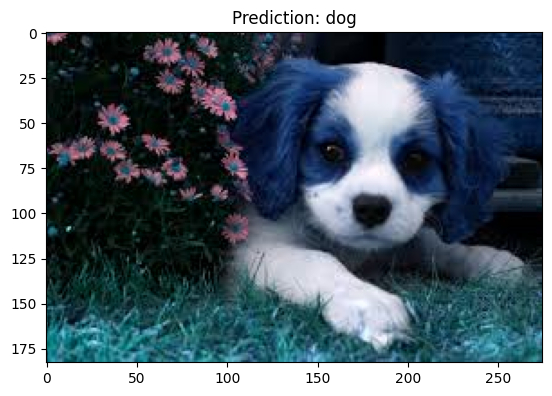

1


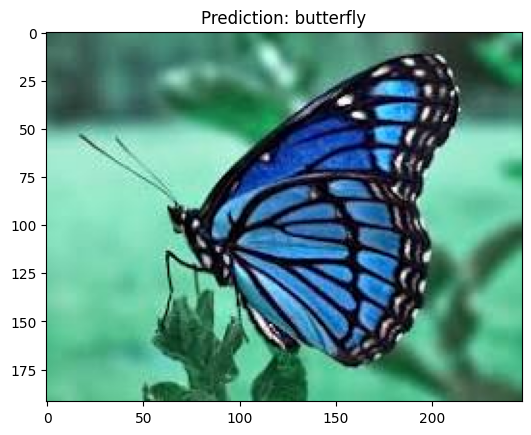

In [ ]:
# Прогнозирование классов для изображений

dog_img = 'drive/MyDrive/dog.jpeg'
test_img = 'drive/MyDrive/butterflyjpeg.jpeg'

pred = [dog_img, test_img]
arr = []

for img_path in pred:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to read image from path: {img_path}")
        continue
    img = tf.image.resize(img, (256, 256))
    prediction_d = loaded_model.predict(np.expand_dims(img.numpy()/255., axis=0))
    arr.append(prediction_d)

show_img(arr, pred)

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
